In [2]:
import os
import sys
print(os.getcwd())
# Add project root (one level up from data_analysis) to sys.path
sys.path.append(os.path.abspath('..'))

import numpy as np
import powerlaw
import networkx as nx
import matplotlib.pyplot as plt

from helper import graph_analyzer, file_preprocesser

/home/sebastian/OneDrive/Dokumente/FernUni/Komplexe Netze/Code/data_analysis


In [41]:
def find_word_regiment_candidates_grouped(deg_prob_dict, start=0, stop=0, step=1, max_diff=5, group_method="lower"):
    bucket_dict = group_by_power_of_two(deg_prob_dict, group_method=group_method)
    sorted_tuple_list = [(bucket, bucket_dict[bucket]) for bucket in sorted(bucket_dict.keys())]
    res = dict()

    for i in range(start, stop if stop != 0 else len(sorted_tuple_list)-1, step):
        #vielleicht den Schnittpunkt in beide Berechnungen mit aufnehmen?
        left = sorted_tuple_list[start:i+1]
        right = sorted_tuple_list[i:]
        probs_left = [t[1] for t in left]
        probs_right = [t[1] for t in right]
        try:
            powerlaw_left = powerlaw.Fit(probs_left, xmin = min(probs_left) )
            powerlaw_right = powerlaw.Fit(probs_right, xmin= (min(probs_right)))
            #if np.isinf(powerlaw_left.alpha) or np.isinf(powerlaw_right.alpha): continue #doenst work ,,,
            res[i] = { "left": powerlaw_left.alpha, "right": powerlaw_right.alpha}
        except Exception as e:
            print(f"Skipping {i} due to error: {e}")
            continue

    #sort by difference between left-right regmiment, desc
    res = dict(filter(lambda item: abs(item[1]["left"] - item[1]["right"]) <= max_diff, res.items()))
    res = dict(sorted(
        res.items(), 
        key=lambda item: abs(item[1]["left"] - item[1]["right"]),
        reverse=True
        ))
    return res

def group_by_power_of_two(deg_prob_dict, group_method="lower"):
    max_deg = max(deg_prob_dict.keys())
    bucket_dict = dict()
    for deg, prob in deg_prob_dict.items():
        if group_method == "lower":
            bucket = 2 ** int(np.floor(np.log2(deg)))
        elif group_method == "upper":
            bucket = 2 ** int(np.ceil(np.log2(deg)))
        #print(str.format("deg: {0}, bin: {1}", deg, bucket))
        if bucket not in bucket_dict:
            bucket_dict[bucket] = prob
        else:
            bucket_dict[bucket] = bucket_dict[bucket] + prob
    print(str.format("Anzahl der Knotengrade: {0}, max degree: {1}, Anzahl Buckets: {2}", len(deg_prob_dict), max_deg, len(bucket_dict)))
    return bucket_dict
	
def get_deg_probability_dict(graph):
    deg_frequency_list = np.array(nx.degree_histogram(graph))
    total_nodes = graph.order()
    res = {}
    for deg in range(len(deg_frequency_list)):
        if deg_frequency_list[deg] == 0: continue
        else:
            res[deg] = deg_frequency_list[deg] / total_nodes
    return res

def get_node_count_per_bucket(G: nx.Graph, grouped_dict ,group_method="lower"):
    deg_hist = np.array(nx.degree_histogram(G))
    res = dict.fromkeys(grouped_dict, 0)
    print(deg_hist)
    for deg in range(len(deg_hist)):
        if deg_hist[deg] == 0: continue
        if group_method == "lower":
            bucket = 2 ** int(np.floor(np.log2(deg)))
        elif group_method == "upper":
            bucket = 2 ** int(np.ceil(np.log2(deg)))
        res[bucket] = res[bucket] + deg_hist[deg]
    return res

#Visualisierung
def grouped_deg_prob_scatter_plot(grouped_dict):
    x = np.array(list(grouped_dict.keys()), dtype=int) #degree buckets
    y = np.array(list(grouped_dict.values()),dtype=float) #prob values
    plt.scatter(x, y)
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("deg")
    plt.ylabel("p(deg)")
    plt.grid(True)
    plt.show()

### Graph erzeugen

In [48]:
with open("../data/input/ALL_ALLmitMann_de.txt") as f:
    text = " ".join(f.readlines())
tokens = file_preprocesser.prepare_text_with_libraries(text, remove_stopwords=False, language="de")
G = file_preprocesser.convert_preprocessed_tokens_to_graph(tokens, neighbour_distance=2)

## Gruppierung und mögliche Trennungen

In [49]:
print(G.order())
print(len(G.edges()))
deg_prob_dict = get_deg_probability_dict(G)

92862
1535363


In [61]:
regiment_candidates = find_word_regiment_candidates_grouped(deg_prob_dict, max_diff=10, start=1, group_method="lower")
for split_at, vals in regiment_candidates.items():
    print(str.format("Trennung bei Bucket Nr.: {0} mit Wert {1} -> links: {2:.4f} / rechts: {3:.4f}", 
                     split_at, 2**split_at, vals["left"], vals["right"]))

Anzahl der Knotengrade: 1029, max degree: 53890, Anzahl Buckets: 16
Trennung bei Bucket Nr.: 14 mit Wert 16384 -> links: 1.1822 / rechts: 5.9326
Trennung bei Bucket Nr.: 4 mit Wert 16 -> links: 2.2090 / rechts: 1.2166
Trennung bei Bucket Nr.: 5 mit Wert 32 -> links: 2.2224 / rechts: 1.2335
Trennung bei Bucket Nr.: 13 mit Wert 8192 -> links: 1.2552 / rechts: 2.0701
Trennung bei Bucket Nr.: 3 mit Wert 8 -> links: 1.9879 / rechts: 1.2021
Trennung bei Bucket Nr.: 2 mit Wert 4 -> links: 1.9377 / rechts: 1.1879
Trennung bei Bucket Nr.: 6 mit Wert 64 -> links: 1.9482 / rechts: 1.2546
Trennung bei Bucket Nr.: 12 mit Wert 4096 -> links: 1.2604 / rechts: 1.7134
Trennung bei Bucket Nr.: 7 mit Wert 128 -> links: 1.7308 / rechts: 1.2823
Trennung bei Bucket Nr.: 11 mit Wert 2048 -> links: 1.2957 / rechts: 1.5424
Trennung bei Bucket Nr.: 8 mit Wert 256 -> links: 1.5521 / rechts: 1.3195
Trennung bei Bucket Nr.: 10 mit Wert 1024 -> links: 1.3391 / rechts: 1.4412
Trennung bei Bucket Nr.: 9 mit Wert 512 

Not enough data. Returning nan


In [62]:
regiment_candidates = find_word_regiment_candidates_grouped(deg_prob_dict, max_diff=10, start=1, group_method="upper")
for split_at, vals in regiment_candidates.items():
    print(str.format("Trennung bei Bucket Nr.: {0} mit Wert {1} -> links: {2:.4f} / rechts: {3:.4f}", 
                     split_at, 2**split_at, vals["left"], vals["right"]))

Anzahl der Knotengrade: 1029, max degree: 53890, Anzahl Buckets: 17
Trennung bei Bucket Nr.: 15 mit Wert 32768 -> links: 1.1848 / rechts: 5.9326
Trennung bei Bucket Nr.: 14 mit Wert 16384 -> links: 1.2628 / rechts: 2.0701
Trennung bei Bucket Nr.: 13 mit Wert 8192 -> links: 1.2708 / rechts: 1.7134
Trennung bei Bucket Nr.: 12 mit Wert 4096 -> links: 1.3132 / rechts: 1.5424
Trennung bei Bucket Nr.: 2 mit Wert 4 -> links: 1.3583 / rechts: 1.1814
Trennung bei Bucket Nr.: 3 mit Wert 8 -> links: 1.3069 / rechts: 1.1930
Trennung bei Bucket Nr.: 4 mit Wert 16 -> links: 1.2905 / rechts: 1.2038
Trennung bei Bucket Nr.: 11 mit Wert 2048 -> links: 1.3687 / rechts: 1.4412
Trennung bei Bucket Nr.: 5 mit Wert 32 -> links: 1.2868 / rechts: 1.2172
Trennung bei Bucket Nr.: 6 mit Wert 64 -> links: 1.2903 / rechts: 1.2339
Trennung bei Bucket Nr.: 7 mit Wert 128 -> links: 1.2982 / rechts: 1.2549
Trennung bei Bucket Nr.: 8 mit Wert 256 -> links: 1.3107 / rechts: 1.2825
Trennung bei Bucket Nr.: 10 mit Wert 10

Not enough data. Returning nan


Anzahl der Knotengrade: 1029, max degree: 53890, Anzahl Buckets: 16


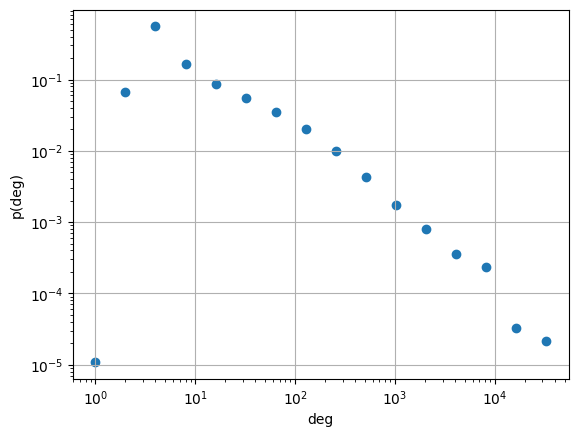

In [57]:
grouped_deg_prob_scatter_plot(group_by_power_of_two(get_deg_probability_dict(G), group_method="lower"))

Anzahl der Knotengrade: 1029, max degree: 53890, Anzahl Buckets: 17


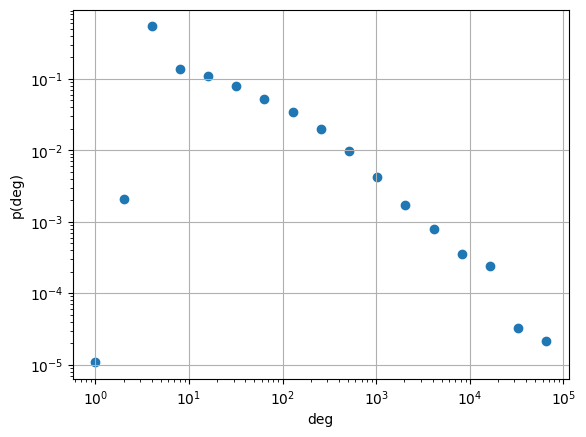

In [58]:
grouped_deg_prob_scatter_plot(group_by_power_of_two(get_deg_probability_dict(G), group_method="upper"))

In [21]:
deg_prob_dict = get_deg_probability_dict(G)
lastBucket = [k for k in deg_prob_dict.keys() if k > 32768]
print(lastBucket)

[40226]


In [55]:
deg_prob_dict = get_deg_probability_dict(G)
grouped = group_by_power_of_two(deg_prob_dict, group_method="lower")
node_count_per_bucket = get_node_count_per_bucket(G, grouped, group_method="lower")
for k, v in node_count_per_bucket.items():
    print(str.format("bucket: {0}, count: {1}", k, v))

Anzahl der Knotengrade: 1029, max degree: 53890, Anzahl Buckets: 16
[  0   1 191 ...   0   0   1]
bucket: 1, count: 1
bucket: 2, count: 6134
bucket: 4, count: 51760
bucket: 8, count: 15145
bucket: 16, count: 8051
bucket: 32, count: 5045
bucket: 64, count: 3225
bucket: 128, count: 1876
bucket: 256, count: 930
bucket: 512, count: 401
bucket: 1024, count: 160
bucket: 2048, count: 74
bucket: 4096, count: 33
bucket: 8192, count: 22
bucket: 16384, count: 3
bucket: 32768, count: 2


In [56]:
deg_prob_dict = get_deg_probability_dict(G)
grouped = group_by_power_of_two(deg_prob_dict, group_method="upper")
node_count_per_bucket = get_node_count_per_bucket(G, grouped, group_method="upper")
for k, v in node_count_per_bucket.items():
    print(str.format("bucket: {0}, count: {1}", k, v))

Anzahl der Knotengrade: 1029, max degree: 53890, Anzahl Buckets: 17
[  0   1 191 ...   0   0   1]
bucket: 1, count: 1
bucket: 2, count: 191
bucket: 4, count: 50711
bucket: 8, count: 12637
bucket: 16, count: 10376
bucket: 32, count: 7456
bucket: 64, count: 4868
bucket: 128, count: 3153
bucket: 256, count: 1852
bucket: 512, count: 924
bucket: 1024, count: 399
bucket: 2048, count: 160
bucket: 4096, count: 74
bucket: 8192, count: 33
bucket: 16384, count: 22
bucket: 32768, count: 3
bucket: 65536, count: 2


In [40]:
sum = 0
for v in node_count_per_bucket.values():
    sum += v

print(sum == G.order())

True
